# ガウス過程によるモデリング

参考にしたサイト>> http://nykergoto.hatenablog.jp/entry/2017/05/29/python%E3%81%A7%E3%82%AC%E3%82%A6%E3%82%B9%E9%81%8E%E7%A8%8B%E5%9B%9E%E5%B8%B0_~_%E3%83%A2%E3%82%B8%E3%83%A5%E3%83%BC%E3%83%AB%E3%81%AE%E6%AF%94%E8%BC%83_~

ライブラリをインポートする

In [3]:
from sklearn.gaussian_process import kernels as sk_kern
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from mpl_toolkits.mplot3d import Axes3D

In [4]:
data = np.loadtxt("data/lorentz_v2.csv",delimiter=",")
print(data.shape)

(4, 50001)


教師データを読み込む

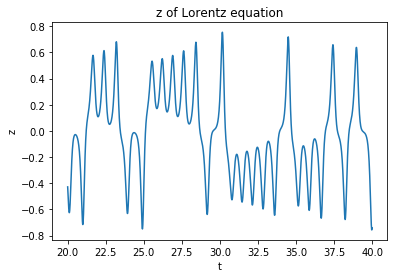

In [5]:
#データをまず可視化する
start_point = 10000 # 元データのスタート地点
end_point = 20000 #元データの終了地点
N_samp = 4 #元データからのサンプリング幅





T = data[0, start_point:end_point:N_samp] 
teacher = data[1, start_point:end_point:N_samp] / np.mean(np.abs(data[3, start_point:end_point:N_samp])) 
plt.plot(T, teacher)
plt.title("z of Lorentz equation")
plt.xlabel("t")
plt.ylabel("z")
plt.show()

ガウス過程をしてみる


In [6]:
kernel = sk_kern.RBF(2.0, (1e-3, 1e3)) + sk_kern.ConstantKernel(1.0, (1e-3, 1e3)) + sk_kern.WhiteKernel()
clf = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-10, 
    optimizer="fmin_l_bfgs_b", 
    n_restarts_optimizer=20,
    normalize_y=True)

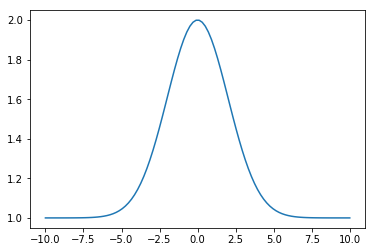

In [7]:
# 可視化は定義されていないので自分で用意する必要あり
X = np.linspace(-10, 10, 100)
plt.plot(X, kernel(X.reshape(-1, 1), np.array([[0.]])))
plt.show()

In [8]:
#学習に使えるデータの大きさ
N4L = 1400

# m_t  はn+1ステップを予測するための時系列のサンプル数
m_t = 20
x_train = np.array([teacher[ii : ii + m_t ] for ii in range( N4L - m_t)])
y_train = teacher[m_t:N4L]
print("shape x_train", x_train.shape)
print("shape y_train", y_train.shape)

shape x_train (1380, 20)
shape y_train (1380,)


In [9]:
# ある時系列から入力データに変換する
def convert2input(arr, m_t):
    if (len(arr)<m_t):
        print("input length must be longer than ", m_t)
    else:
        return arr[:m_t]

In [ ]:
print(x_train.shape)
# X は (n_samples, n_features) の shape に変形する必要がある
clf.fit(x_train, y_train)

(1380, 20)


In [ ]:
# パラメータ学習後のカーネルは self.kernel_ に保存される
clf.kernel_

In [ ]:
x_test = x_train[-1]
print(x_test)
print(x_test.shape)

print(x_test.reshape(-1, 1).shape)
std_test = np.zeros(m_t)
print("std_test", std_test.shape)

In [ ]:
# 予測の長さ
len_pred = 3000

for ii in range(len_pred ):
    
    # 予測は平均値と、オプションで 分散、共分散 を得ることが出来る
    pred_mean, pred_std= clf.predict(x_test[-m_t:].reshape(1, -1), return_std=True)
    #print(pred_mean.shape)
    #print(pred_std.shape)
    x_test = np.append(x_test, pred_mean)
    std_test = np.append(std_test, pred_std)
    
mean_pred = x_test[m_t:]
std_pred = std_test[m_t:]


print("shape mean_pred", mean_pred.shape)
print("shape std_pred", std_pred.shape)

In [ ]:
len_plt2 = 400

plt.plot(T[:N4L+len_plt2], teacher[:N4L+len_plt2], "--", color="green", label="True Function", alpha = 1.0)
plt.plot(T[N4L:N4L+len_plt2], mean_pred[:len_plt2], color="C0", label="predict mean")
plt.vlines(T[N4L], ymax=np.max(teacher), ymin=np.min(teacher), linestyles="dotted", alpha=0.7)
#plt.fill_between(T[N4L:N4L+len_pred], mean_pred + std_pred, mean_pred - std_pred, color="C0", alpha=.5,label= "1 sigma confidence")
plt.title("Time Prediction")
plt.legend()
plt.savefig("sklern_time_Lorentz_predict_z.png", dpi=200)

In [ ]:
def trans_2_emb(arr, tau, mm):
    #print(arr.shape[0])
    teacher_emb = np.empty((mm, arr.shape[0]-tau * mm))
    for ii in range(mm): 
        teacher_emb[ii, :] = arr[tau*ii:arr.shape[0]-tau* (mm- ii)]
    return teacher_emb

可視化してみる

In [ ]:
tau =10
MM =  3

In [ ]:
# 教師データ

te_emb = trans_2_emb(teacher[:N4L+len_pred], tau,  MM)

fig3d_te = plt.figure()

ax3d_te   = fig3d_te.add_subplot(111, projection='3d')   # <- axes3dをインポートしていないとエラーになる。
ax3d_te.scatter(te_emb[0,:], te_emb[1,:], te_emb[2,:],c="black", s=5)
ax3d_te.set_xlabel('x',fontsize=23)
ax3d_te.set_ylabel('y',fontsize=23)
ax3d_te.set_zlabel('z',fontsize=23)
ax3d_te.axis('equal')

plt.show()

In [ ]:
# 予測データ

pr_emb = trans_2_emb(mean_pred, tau,  MM)

fig3d_pr = plt.figure()

ax3d_pr   = fig3d_pr.add_subplot(111, projection='3d')   # <- axes3dをインポートしていないとエラーになる。
ax3d_pr.scatter(pr_emb[0,:], pr_emb[1,:], pr_emb[2,:],c="black", s=5)
ax3d_pr.set_xlabel('x',fontsize=23)
ax3d_pr.set_ylabel('y',fontsize=23)
ax3d_pr.set_zlabel('z',fontsize=23)
ax3d_pr.axis('equal')

plt.show()